In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import csv
import matplotlib.lines as mlines
plt.style.use(plt.style.available[11])

In [2]:
noises = [30]
models = ['svr', 'gpr'] #['train', 'svr', 'gpr', 'nn']
print(noises)
fuchs_results = pd.read_csv('predictions_dfs/fuchs.csv')

[30]


In [3]:
def calc_laser_energy(I0, w0=1.5e-6, tFWHM=40.0e-15):
    return (np.pi/2)*I0*w0**2 * tFWHM # For a Sine-Squared Pulse
print('min laser energy: ', calc_laser_energy(1e22)*1e3, 'mJ')
print('max laser energy: ', calc_laser_energy(1e23)*1e3, 'mJ')

min laser energy:  1.4137166941154071 mJ
max laser energy:  14.137166941154067 mJ


# Define Objective Function
- balance between matching energy to specified cutoff and obtaining a laser energy to proton energy conversion efficiency

In [4]:
def objective_function(x, E_cutoff=0.1, η=0.5, penalty=True, only_term2 = False):
    Intensity = x[0] # Laser Intensity
    Thickness = x[1] # Target Thickness
    Offset = x[2] # Focal Offset
    E_max = x[3] # Max Energy
    E_tot = x[4] # Total Energy
    E_avg = x[5] # Average Energy
    Laser_Energy = calc_laser_energy(Intensity*1e4)
    Conversion_Efficiency = (E_tot*1.609e-13)/Laser_Energy
    N_p = E_tot/E_avg
    term1 = np.abs(E_max - E_cutoff)/E_cutoff if not only_term2 else 0 # Wanting to Match E_max to E_cutoff
    term2 = η*(4.5e-3)/Conversion_Efficiency    # Wanting to obtain high conversion efficiency
    penalty_term = 1e6 if (np.abs(E_max-E_cutoff)/E_cutoff > 0.15 and penalty==True) else 0 # Penalizing if E_max is too far from E_cutoff
    obj = term1 + term2 + penalty_term
    return obj

def model(x):
    Intensity = x.iloc[:, 0] # Laser Intensity
    Thickness = x.iloc[:, 1] # Target Thickness
    Offset = x.iloc[:, 2] # Focal Offset
    E_max = x.iloc[:, 3] # Max Energy
    E_tot = x.iloc[:, 4] # Total Energy
    E_avg = x.iloc[:, 5] # Average Energy
    Laser_Energy = calc_laser_energy(Intensity*1e4)
    Conversion_Efficiency = (E_tot*1.609e-13)/Laser_Energy
    return Conversion_Efficiency, E_tot, Laser_Energy


C:\Users\ronak\AppData\Local\Temp\ipykernel_16076\2061406100.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Intensity = x[0] # Laser Intensity
C:\Users\ronak\AppData\Local\Temp\ipykernel_16076\2061406100.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Thickness = x[1] # Target Thickness
C:\Users\ronak\AppData\Local\Temp\ipykernel_16076\2061406100.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Offset = x[2] # Focal Offs

KeyboardInterrupt: 

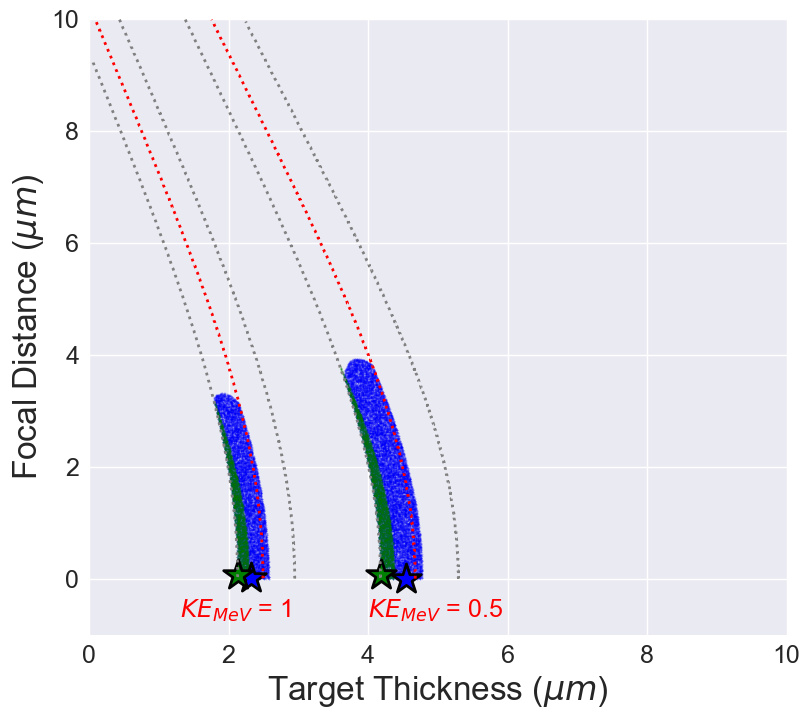

In [5]:
E_cutoffs = [1, 0.5, 0.25] # Energy cutoffs for the protons (MeV)
etas = [1, 0.4, 0.175] # Weighting for conversion efficiency term
thick_xs = [1.3, 4, 6.9] # x locations for text labels

bounds = [(1e19, 1e19), (0.0, 10.0), (-1, 10.0)]
colors = ['blue', 'green', 'red']
threshold = 5 # region of best points are within (threshold) pct of optimal value
tol = 1e-2

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9,8))
size1 = 1
size2 = 500

ax.set_xlabel('Target Thickness ($\mu m$)', fontsize=24)
ax.set_ylabel('Focal Distance ($\mu m$)', fontsize=24)
ax.set_xlim(bounds[1])
ax.set_ylim(bounds[2])
ax.tick_params(axis='both',  labelsize=18)
ax.set_axisbelow(True)

for i in range(len(E_cutoffs)):
    E_cutoff = E_cutoffs[i]
    η = etas[i]

    # Blue Region: Balance both term1 and term2
    fuchs_results_1 = fuchs_results.copy()
    fuchs_results_1['objective_function'] = fuchs_results_1.apply(objective_function, args=(E_cutoff, η, True, False), axis=1)
    fuchs_results_1.sort_values(by=['objective_function'], ascending=True, inplace=True)

    # Green Region: Only term2 for high conversion efficiency
    fuchs_results_2 = fuchs_results.copy()
    fuchs_results_2['objective_function'] = fuchs_results_2.apply(objective_function, args=(E_cutoff, η, True, True), axis=1)
    fuchs_results_2.sort_values(by=['objective_function'], ascending=True, inplace=True)

    # Left Gray Line: Higher energy contour for E_max from penalty term
    fuchs_results_3 = fuchs_results.copy()
    fuchs_results_3 = fuchs_results_3.loc[((fuchs_results_3['E Max']-E_cutoff)/E_cutoff < 0.151) & ((fuchs_results_3['E Max']-E_cutoff)/E_cutoff > 0.149)]
    fuchs_results_3.sort_values(by=['Offset'], ascending=True, inplace=True)

    # Right Gray Line: Lower energy contour for E_max from penalty term
    fuchs_results_4 = fuchs_results.copy()
    fuchs_results_4 = fuchs_results_4.loc[((fuchs_results_4['E Max']-E_cutoff)/E_cutoff > -0.151) & ((fuchs_results_4['E Max']-E_cutoff)/E_cutoff < -0.149)]
    fuchs_results_4.sort_values(by=['Offset'], ascending=True, inplace=True)

    # Red Line: Center energy contour (i.e. E_max = E_cutoff) for E_max from penalty term
    fuchs_results_5 = fuchs_results.copy()
    fuchs_results_5 = fuchs_results_5.loc[((fuchs_results_5['E Max']-E_cutoff)/E_cutoff > -0.001) & ((fuchs_results_5['E Max']-E_cutoff)/E_cutoff < 0.001)]
    fuchs_results_5.sort_values(by=['Offset'], ascending=True, inplace=True)

    ax.plot(fuchs_results_3['Thickness'], fuchs_results_3['Offset'], color='gray', linewidth=2, linestyle='dotted')
    ax.plot(fuchs_results_4['Thickness'], fuchs_results_4['Offset'], color='gray', linewidth=2, linestyle='dotted')
    ax.plot(fuchs_results_5['Thickness'], fuchs_results_5['Offset'], color='red', linewidth=2, linestyle='dotted')

    # np.save('npy_files/fuchs_thickness_left_E={}.npy'.format(E_cutoff), fuchs_results_3['Thickness'].values)
    # np.save('npy_files/fuchs_offset_left_E={}.npy'.format(E_cutoff), fuchs_results_3['Offset'].values)
    # np.save('npy_files/fuchs_thickness_right_E={}.npy'.format(E_cutoff), fuchs_results_4['Thickness'].values)
    # np.save('npy_files/fuchs_offset_right_E={}.npy'.format(E_cutoff), fuchs_results_4['Offset'].values)
    # np.save('npy_files/fuchs_thickness_center_E={}.npy'.format(E_cutoff), fuchs_results_5['Thickness'].values)
    # np.save('npy_files/fuchs_offset_center_E={}.npy'.format(E_cutoff), fuchs_results_5['Offset'].values)
    
    optimal_value_fuchs_1 = fuchs_results_1['objective_function'].iloc[0]
    locations_fuchs_1 = fuchs_results_1.loc[fuchs_results_1['objective_function'] <= (1 + threshold/100)*optimal_value_fuchs_1 + tol]
    ax.scatter(locations_fuchs_1['Thickness'], locations_fuchs_1['Offset'], color='blue', s=size1) 

    optimal_value_fuchs_2 = fuchs_results_2['objective_function'].iloc[0]
    locations_fuchs_2 = fuchs_results_2.loc[fuchs_results_2['objective_function'] <= (1 + threshold/100)*optimal_value_fuchs_2 + tol]
    ax.scatter(locations_fuchs_2['Thickness'], locations_fuchs_2['Offset'], color='green', s=size1)

    ax.scatter(fuchs_results_1['Thickness'].iloc[0], fuchs_results_1['Offset'].iloc[0], color='blue', marker='*', s=size2, edgecolor='black', linewidth=2)
    ax.scatter(fuchs_results_2['Thickness'].iloc[0], fuchs_results_2['Offset'].iloc[0], color='green', marker='*', s=size2, edgecolor='black', linewidth=2)

    ax.text(thick_xs[i], -0.7, '$KE_{MeV}$ = ' + '{}'.format(E_cutoff), fontsize=18, color='red')

ax.text(0.95, 3, '$KE_{MeV}$ = 1.15', fontsize=14, color='gray', rotation=-72)
ax.text(2.2, 3, '$KE_{MeV}$ = 0.85', fontsize=14, color='gray', rotation=-73)
ax.text(1.7, 6, '$KE_{MeV}$ = 0.575', fontsize=14, color='gray', rotation=-65)
ax.text(3.15, 6, '$KE_{MeV}$ = 0.425', fontsize=14, color='gray', rotation=-63)
ax.text(5.35, 3, '$KE_{MeV}$ = 0.288', fontsize=14, color='gray', rotation=-65)
ax.text(7.3, 3, '$KE_{MeV}$ = 0.213', fontsize=14, color='gray', rotation=-63)

# Create Line2D instances for the legend
green_patch = mlines.Line2D([], [], color='green', marker='o', markersize=size1*5, label='High $\eta_{proton}$', linestyle='None')
blue_patch = mlines.Line2D([], [], color='blue', marker='o', markersize=size1*5, label='Near Minimum of eq. (2)', linestyle='None')
green_star = mlines.Line2D([], [], color='green', marker='*', markersize=size1*20, label='Highest $\eta_{proton}$', linestyle='None')
blue_star = mlines.Line2D([], [], color='blue', marker='*', markersize=size1*20, label='Minimum of eq. (2)', linestyle='None')

# Add the custom legend to the subplot
ax.legend(handles=[green_patch, green_star, blue_patch, blue_star], bbox_to_anchor=(1.05, 1.02), loc='upper right', fontsize=16)

In [ ]:
fig.savefig('plots/fuchs_optim.jpeg', dpi=300, bbox_inches='tight')

Below: evaluating objective function on fuchs model with added noise directly is not a good idea:

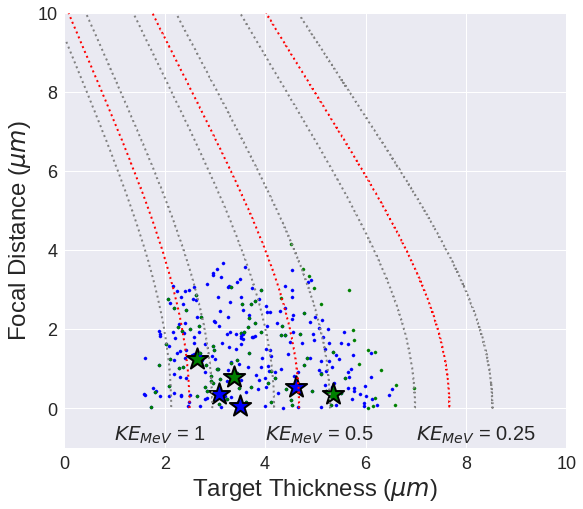

In [ ]:
n_points = 10000
fuchs_results_noise = pd.read_csv('predictions_dfs/fuchs_{}.csv'.format(n_points))

E_cutoffs = [1, 0.5, 0.25]
etas = [1, 0.4, 0.175]
thick_xs = [1, 4, 7]

bounds = [(1e19, 1e19), (0.0, 10.0), (-1, 10.0)]
colors = ['blue', 'green', 'red']
threshold = 5 # banana of best points within (threshold) pct of optimal value
tol = 1e-2
j=0 # noise level
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9,8))
size1 = 10
size2 = 500
alpha = 1

ax.set_xlabel('Target Thickness ($\mu m$)', fontsize=24)
ax.set_ylabel('Focal Distance ($\mu m$)', fontsize=24)
ax.set_xlim(bounds[1])
ax.set_ylim(bounds[2])
ax.tick_params(axis='both',  labelsize=18)
ax.set_axisbelow(True)

for i in range(len(E_cutoffs)):
    E_cutoff = E_cutoffs[i]
    η = etas[i]

    # Blue Region: Balance both term1 and term2
    fuchs_results_1 = fuchs_results_noise.copy()
    fuchs_results_1['objective_function'] = fuchs_results_1.apply(objective_function, args=(E_cutoff, η, True, False), axis=1)
    fuchs_results_1.sort_values(by=['objective_function'], ascending=True, inplace=True)

    # Green Region: Only term2 for high conversion efficiency
    fuchs_results_2 = fuchs_results_noise.copy()
    fuchs_results_2['objective_function'] = fuchs_results_2.apply(objective_function, args=(E_cutoff, η, True, True), axis=1)
    fuchs_results_2.sort_values(by=['objective_function'], ascending=True, inplace=True)

    # Left Gray Line: Higher energy contour for E_max from penalty term
    fuchs_results_3 = fuchs_results.copy()
    fuchs_results_3 = fuchs_results_3.loc[((fuchs_results_3['E Max']-E_cutoff)/E_cutoff < 0.151) & ((fuchs_results_3['E Max']-E_cutoff)/E_cutoff > 0.149)]
    fuchs_results_3.sort_values(by=['Offset'], ascending=True, inplace=True)

    # Right Gray Line: Lower energy contour for E_max from penalty term
    fuchs_results_4 = fuchs_results.copy()
    fuchs_results_4 = fuchs_results_4.loc[((fuchs_results_4['E Max']-E_cutoff)/E_cutoff > -0.151) & ((fuchs_results_4['E Max']-E_cutoff)/E_cutoff < -0.149)]
    fuchs_results_4.sort_values(by=['Offset'], ascending=True, inplace=True)

    # Red Line: Center energy contour (i.e. E_max = E_cutoff) for E_max from penalty term
    fuchs_results_5 = fuchs_results.copy()
    fuchs_results_5 = fuchs_results_5.loc[((fuchs_results_5['E Max']-E_cutoff)/E_cutoff > -0.001) & ((fuchs_results_5['E Max']-E_cutoff)/E_cutoff < 0.001)]
    fuchs_results_5.sort_values(by=['Offset'], ascending=True, inplace=True)

    ax.plot(fuchs_results_3['Thickness'], fuchs_results_3['Offset'], color='gray', linewidth=2, linestyle='dotted')
    ax.plot(fuchs_results_4['Thickness'], fuchs_results_4['Offset'], color='gray', linewidth=2, linestyle='dotted')
    ax.plot(fuchs_results_5['Thickness'], fuchs_results_5['Offset'], color='red', linewidth=2, linestyle='dotted')

#     np.save('npy_files/fuchs_thickness_left_E={}.npy'.format(E_cutoff), fuchs_results_3['Thickness'].values)
#     np.save('npy_files/fuchs_offset_left_E={}.npy'.format(E_cutoff), fuchs_results_3['Offset'].values)
#     np.save('npy_files/fuchs_thickness_right_E={}.npy'.format(E_cutoff), fuchs_results_4['Thickness'].values)
#     np.save('npy_files/fuchs_offset_right_E={}.npy'.format(E_cutoff), fuchs_results_4['Offset'].values)
#     np.save('npy_files/fuchs_thickness_center_E={}.npy'.format(E_cutoff), fuchs_results_5['Thickness'].values)
#     np.save('npy_files/fuchs_offset_center_E={}.npy'.format(E_cutoff), fuchs_results_5['Offset'].values)
    
    optimal_value_fuchs_1 = fuchs_results_1['objective_function'].iloc[0]
    locations_fuchs_1 = fuchs_results_1.loc[fuchs_results_1['objective_function'] <= (1 + threshold/100)*optimal_value_fuchs_1 + tol]
    ax.scatter(locations_fuchs_1['Thickness'], locations_fuchs_1['Offset'], label='Mix', color='blue', alpha=alpha, s=size1) 

    optimal_value_fuchs_2 = fuchs_results_2['objective_function'].iloc[0]
    locations_fuchs_2 = fuchs_results_2.loc[fuchs_results_2['objective_function'] <= (1 + threshold/100)*optimal_value_fuchs_2 + tol]
    ax.scatter(locations_fuchs_2['Thickness'], locations_fuchs_2['Offset'], label='Max Efficiency', color='green', alpha=alpha, s=size1)

    ax.scatter(fuchs_results_1['Thickness'].iloc[0], fuchs_results_1['Offset'].iloc[0], color='blue', marker='*', s=size2, edgecolor='black', linewidth=2)
    ax.scatter(fuchs_results_2['Thickness'].iloc[0], fuchs_results_2['Offset'].iloc[0], color='green', marker='*', s=size2, edgecolor='black', linewidth=2)

    ax.text(thick_xs[i], -0.8, '$KE_{MeV}$ = ' + '{}'.format(E_cutoff), fontsize=20)
#ax.legend()
#ax.text(0.5, 0.5, 'Noise = {}'.format(noises[j]), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=20)

In [ ]:
fig.savefig('plots/fuchs_optim_{}.jpeg'.format(n_points), dpi=300, bbox_inches='tight')